In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Keras 및 TensorFlow 임포트
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# --- 1. 데이터 로드 ---
# (참고: 이 코드가 작동하려면 동일 디렉토리에 ./data/Training.csv 와 ./data/Testing.csv 파일이 필요합니다.)
try:
    train = pd.read_csv('./Training.csv')
    test = pd.read_csv('./Testing.csv')
    print("데이터 로드 완료.")
except FileNotFoundError:
    print("오류: ./data/Training.csv 또는 ./data/Testing.csv 파일을 찾을 수 없습니다.")
    # 이 경우, 이후 코드는 실행되지 않도록 처리가 필요하지만, 여기서는 파일이 있다고 가정하고 진행합니다.

데이터 로드 완료.


In [2]:
# --- 2. 기본 전처리 ---
# 원본 코드와 동일하게 불필요한 'Unnamed: 133' 컬럼 제거
if 'Unnamed: 133' in train.columns:
    train.drop('Unnamed: 133', axis=1, inplace=True)

print(f"학습 데이터 형태: {train.shape}")
print(f"테스트 데이터 형태: {test.shape}")

학습 데이터 형태: (4920, 133)
테스트 데이터 형태: (42, 133)


EDA 그래프 1: 'disease_distribution.png' 저장 완료.


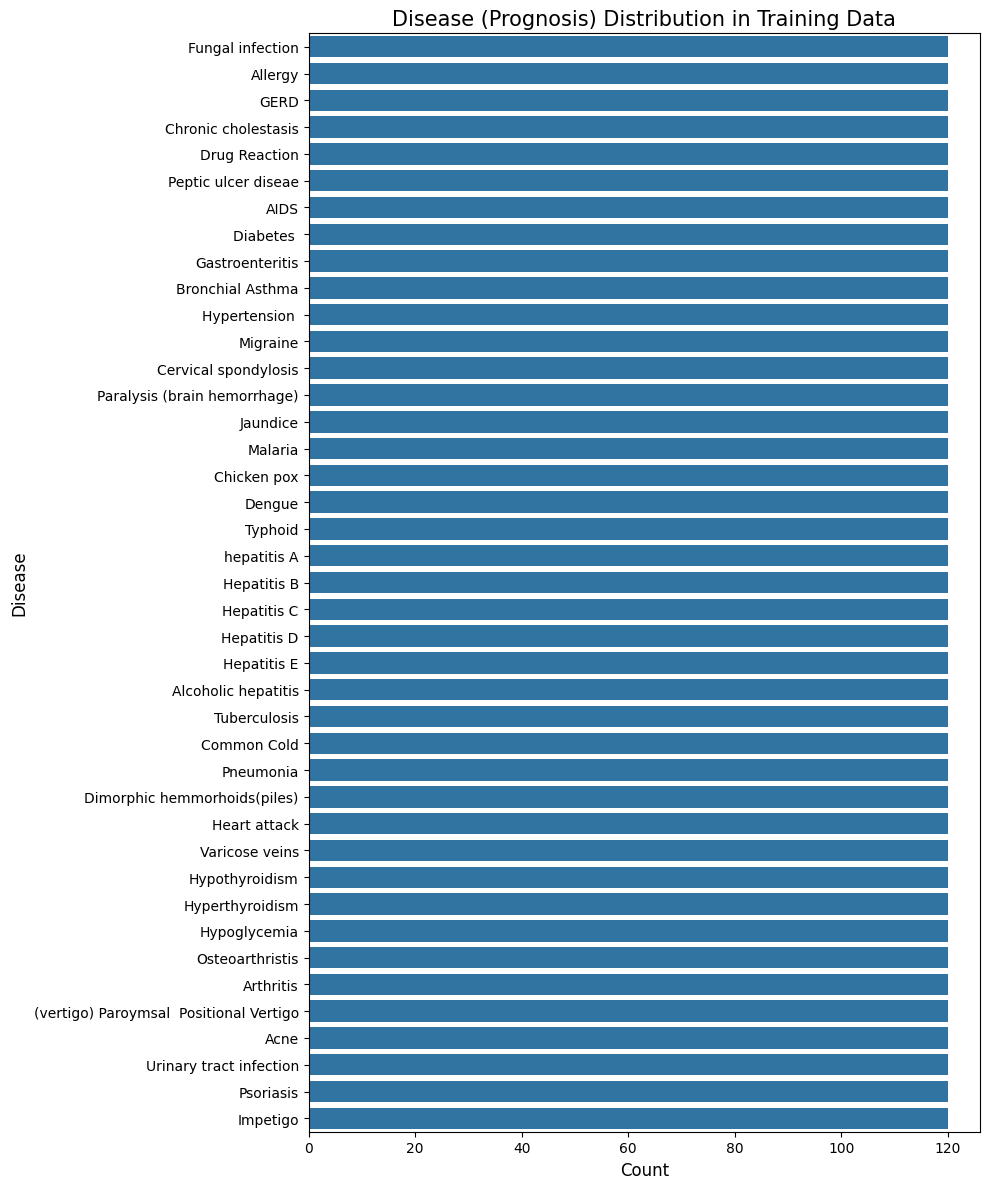

In [3]:
# --- 3. EDA (탐색적 데이터 분석) ---

# EDA 1: 타겟 변수(질병) 분포 확인
plt.figure(figsize=(10, 12))
sns.countplot(y=train['prognosis'], order=train['prognosis'].value_counts().index)
plt.title('Disease (Prognosis) Distribution in Training Data', fontsize=15)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Disease', fontsize=12)
plt.tight_layout()
plt.savefig('disease_distribution.png')
print("EDA 그래프 1: 'disease_distribution.png' 저장 완료.")

EDA 그래프 2: 'symptom_prevalence.png' 저장 완료.


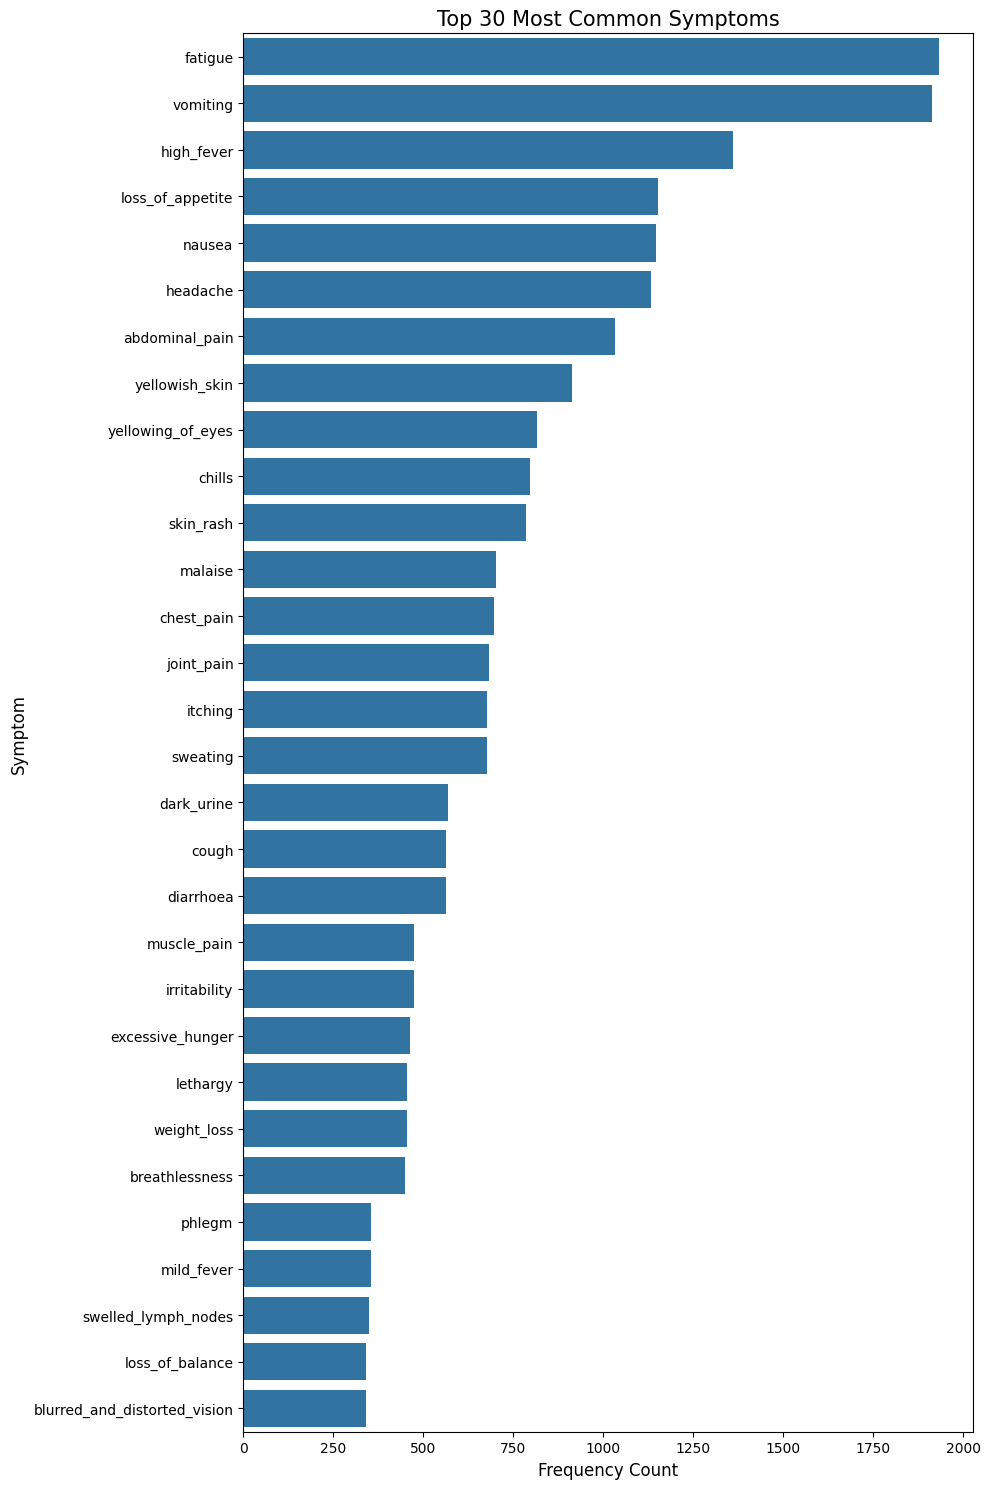

In [5]:
# EDA 2: 증상(Feature) 빈도 확인
# X 데이터만 추출 (prognosis 제외)
symptom_counts = train.drop('prognosis', axis=1).sum().sort_values(ascending=False)

plt.figure(figsize=(10, 15))
# 가장 흔한 증상 30개만 시각화
top_symptoms = symptom_counts.head(30)
sns.barplot(x=top_symptoms.values, y=top_symptoms.index)
plt.title('Top 30 Most Common Symptoms', fontsize=15)
plt.xlabel('Frequency Count', fontsize=12)
plt.ylabel('Symptom', fontsize=12)
plt.tight_layout()
plt.savefig('symptom_prevalence.png')
print("EDA 그래프 2: 'symptom_prevalence.png' 저장 완료.")

In [6]:
# --- 4. 데이터셋 분리 및 인코딩 ---
# 원본 코드와 동일한 로직
X_train = train.drop('prognosis', axis=1)
X_test = test.drop('prognosis', axis=1)

y_train = np.array(train['prognosis'])
y_test = np.array(test['prognosis'])

# 원-핫 인코딩
y_train_enc = pd.get_dummies(y_train)
y_test_enc = pd.get_dummies(y_test)

# 분류 리포트 및 혼동 행렬에 사용할 클래스(질병명) 리스트 확보
class_labels = y_train_enc.columns.tolist()

In [7]:
# --- 5. 딥러닝 모델 구축 ---
# 원본 코드와 동일한 모델 구조
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1], )))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_train_enc.shape[1], activation='softmax')) # 41개 클래스 출력

model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 41)             │           697 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,817 (46.16 KB)

 Trainable params: 11,817 (46.16 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# --- 6. 모델 훈련 ---
early_stopping_monitor = EarlyStopping(patience=2, monitor='val_accuracy')

# history 객체에 훈련 과정을 저장
history = model.fit(
    X_train,
    y_train_enc,
    batch_size=120,
    epochs=30,
    validation_split=0.3,
    callbacks=[early_stopping_monitor],
    verbose=1 # 훈련 과정 출력
)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.0988 - loss: 3.6531 - val_accuracy: 0.2439 - val_loss: 3.3821
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2499 - loss: 3.2915 - val_accuracy: 0.2927 - val_loss: 2.6770
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3636 - loss: 2.5344 - val_accuracy: 0.6585 - val_loss: 1.6188
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7330 - loss: 1.5051 - val_accuracy: 0.9512 - val_loss: 0.6745
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9636 - loss: 0.6299 - val_accuracy: 1.0000 - val_loss: 0.1885
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.2091 - val_accuracy: 1.0000 - val_loss: 0.0533
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9994 - loss: 0.0800 - val_accuracy: 1.0000 - val_loss: 0.0224


In [9]:
# --- 7. 결과 분석 및 시각화 ---

print("\n--- 모델 성능 평가 (Test Data) ---")
# 기본 평가 (Loss, Accuracy)
test_loss, test_accuracy = model.evaluate(X_test, y_test_enc, steps=5)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


--- 모델 성능 평가 (Test Data) ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9921 - loss: 0.0472 
Test Loss: 0.0958
Test Accuracy: 0.9762


In [10]:
# 결과 분석 1 & 2: 훈련/검증 히스토리 시각화 (정확도 및 손실)
history_df = pd.DataFrame(history.history)

결과 그래프 1: 'model_accuracy_history.png' 저장 완료.


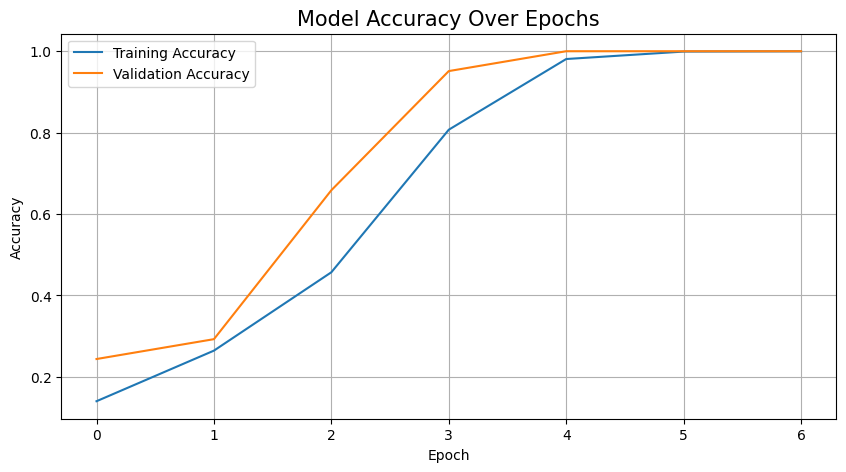

In [11]:
# 정확도 그래프
plt.figure(figsize=(10, 5))
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs', fontsize=15)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('model_accuracy_history.png')
print("결과 그래프 1: 'model_accuracy_history.png' 저장 완료.")

결과 그래프 2: 'model_loss_history.png' 저장 완료.


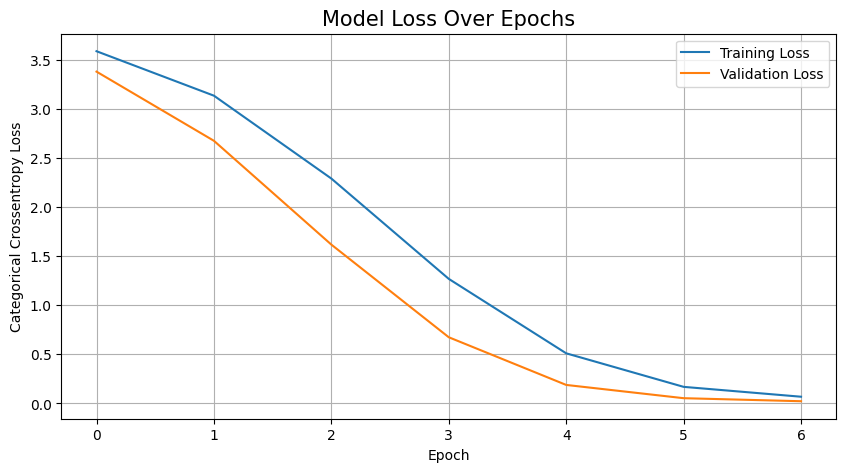

In [12]:
# 손실 그래프
plt.figure(figsize=(10, 5))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs', fontsize=15)
plt.xlabel('Epoch')
plt.ylabel('Categorical Crossentropy Loss')
plt.legend()
plt.grid(True)
plt.savefig('model_loss_history.png')
print("결과 그래프 2: 'model_loss_history.png' 저장 완료.")

In [13]:
# 결과 분석 3: 분류 리포트
# 예측 (확률 -> 클래스 인덱스 -> 클래스 레이블)
y_pred_probs = model.predict(X_test)
y_pred_indices = np.argmax(y_pred_probs, axis=1)
y_pred_labels = [class_labels[i] for i in y_pred_indices]

# 실제값 (원-핫 -> 클래스 인덱스 -> 클래스 레이블)
# (참고: 원본의 y_test는 레이블 문자열이므로 그대로 사용해도 됩니다)
print("\n--- Classification Report (Test Data) ---")
print(classification_report(y_test, y_pred_labels))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

--- Classification Report (Test Data) ---
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       1.00      1.00      1.00         1
                    Chronic cholestasis       1.00      1.00      1.00         1
                           

결과 그래프 3: 'confusion_matrix.png' 저장 완료.


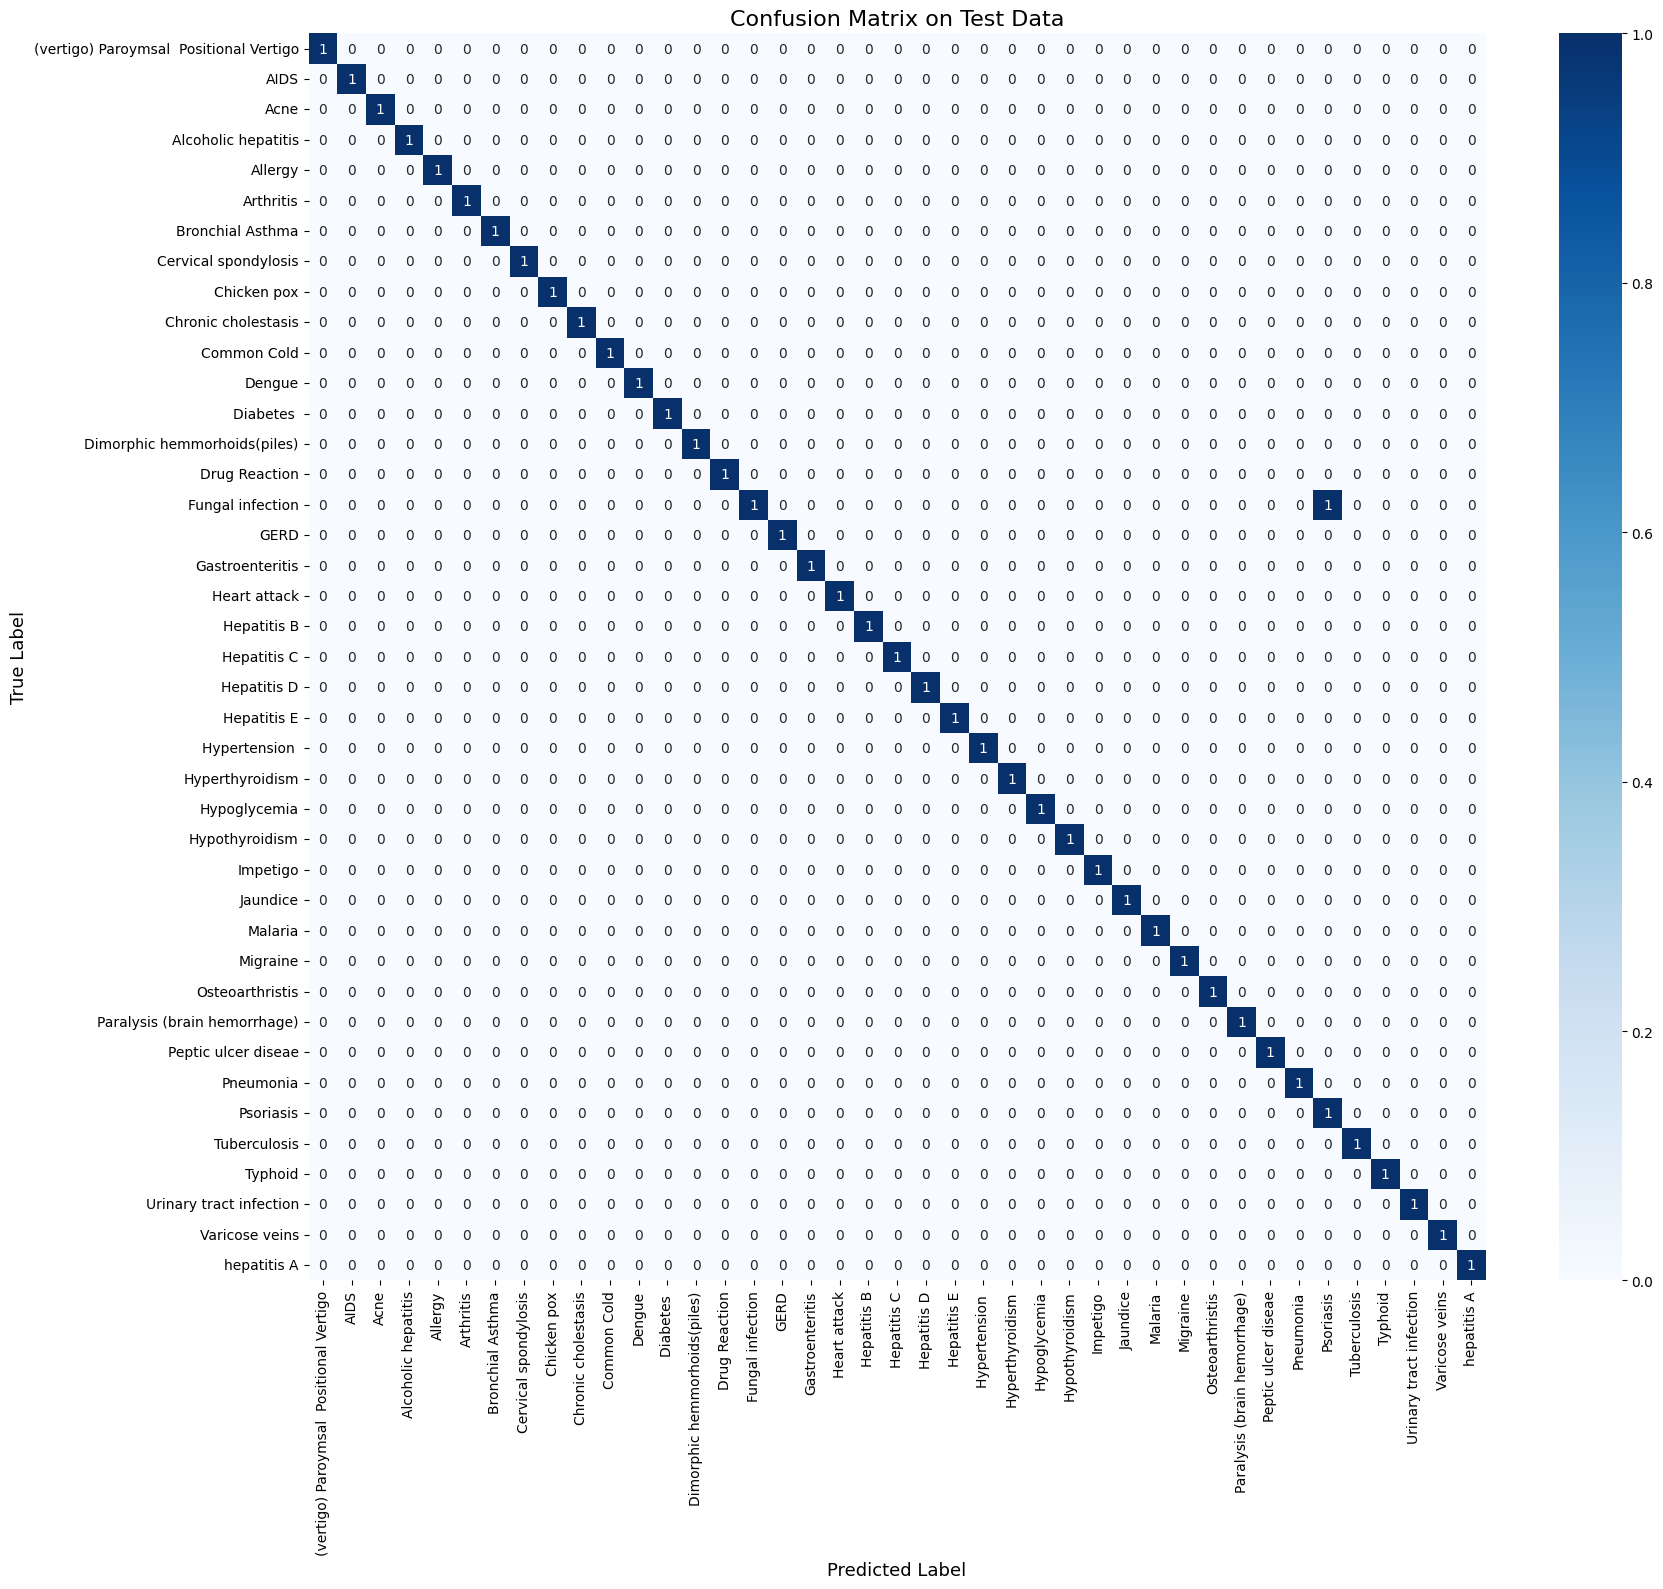

In [14]:
# 결과 분석 4: 혼동 행렬(Confusion Matrix) 시각화
cm = confusion_matrix(y_test, y_pred_labels, labels=class_labels)

plt.figure(figsize=(18, 16)) # 41개 클래스이므로 크게 설정
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix on Test Data', fontsize=16)
plt.xlabel('Predicted Label', fontsize=13)
plt.ylabel('True Label', fontsize=13)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("결과 그래프 3: 'confusion_matrix.png' 저장 완료.")